In [7]:
import cv2
import os
# Seaborn tema ayarı
sns.set_theme(style="ticks")

# Renkli görüntülerin bulunduğu dizin
image_dir = r"C:\Software\bloodcells_dataset"

# Segmente edilmiş görüntülerin kaydedileceği dizin
segmented_image_dir = r"C:\Software\segmented_bloodcells_dataset"

# Eğer segmente edilmiş görüntü dizini yoksa oluştur
if not os.path.exists(segmented_image_dir):
    os.makedirs(segmented_image_dir)

# Alt dizinlerdeki görüntüleri işlemek için os.walk kullanımı
for subdir, dirs, files in os.walk(image_dir):
    for file in files:
        if file.endswith('.jpg') or file.endswith('.png'):  # Görüntü dosya uzantıları
            file_path = os.path.join(subdir, file)
            image = cv2.imread(file_path)
            if image is not None:
                # Otsu eşikleme yöntemi ile segmentasyon
                gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                _, segmented_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

                # Gri tonlamalı görüntünün kaydedileceği alt dizini oluşturma
                relative_path = os.path.relpath(subdir, image_dir)
                output_subdir = os.path.join(segmented_image_dir, relative_path)
                if not os.path.exists(output_subdir):
                    os.makedirs(output_subdir)
                    
                # Segmente edilmiş görüntüyü kaydet
                segmented_image_file = os.path.join(output_subdir, file)
                cv2.imwrite(segmented_image_file, segmented_image)


Found 17092 files belonging to 8 classes.
Using 13674 files for training.
Using 3418 files for validation.
['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


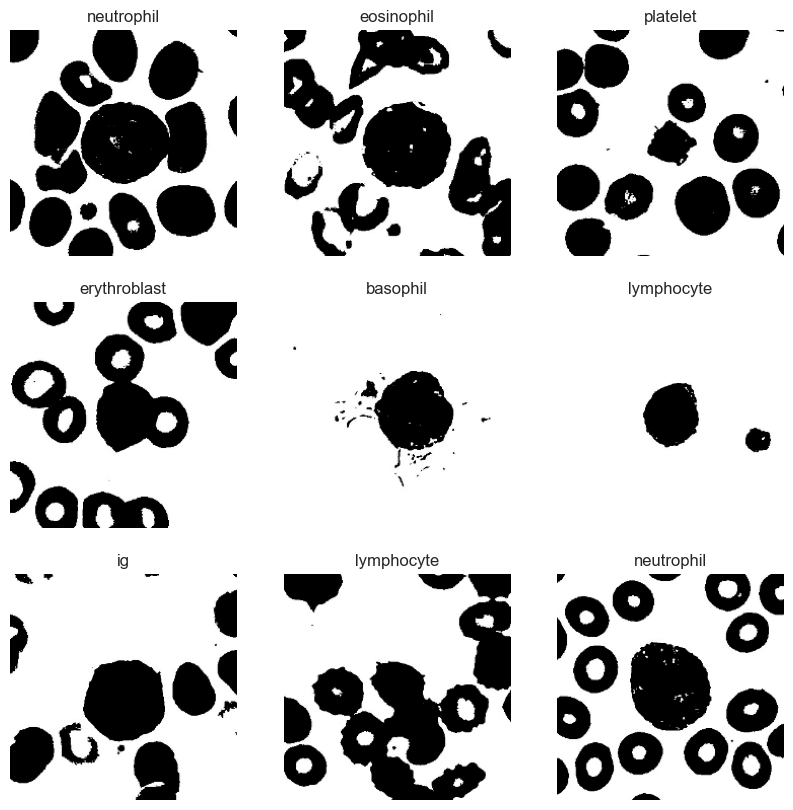

In [9]:
import seaborn as sns
from tensorflow import keras
import matplotlib.pyplot as plt


# Veri kümelerini hazırlama
segmented_image_dir = r"C:\Software\segmented_bloodcells_dataset"

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

segmented_dataset, segmented_test_dataset = keras.utils.image_dataset_from_directory(directory=segmented_image_dir,
                                                                             image_size=(IMG_WIDTH, IMG_HEIGHT),
                                                                             batch_size=BATCH_SIZE,
                                                                             label_mode="int",
                                                                             validation_split=0.2,
                                                                             subset="both",
                                                                             shuffle=True,
                                                                             seed=42)

# Sınıf isimlerini getirme
segmented_class_names = segmented_dataset.class_names
print(segmented_class_names)

# Veri kümesinden örnek görüntüler gösterme
plt.figure(figsize=(10, 10))
for images, labels in segmented_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(segmented_class_names[labels[i]])
        plt.axis("off")
plt.show()

In [10]:
import tensorflow as tf
# Veri kümesini eğitim ve doğrulama setine ayırma 
num_elements = len(segmented_dataset)
train_size = int(0.8 * num_elements)
val_dataset = segmented_dataset.skip(train_size).prefetch(tf.data.AUTOTUNE)
train_dataset = segmented_dataset.take(train_size).prefetch(tf.data.AUTOTUNE)

# uzunlukları kontrol etme 
len(train_dataset), len(val_dataset), len(segmented_test_dataset)

(342, 86, 107)

In [11]:
# Formatı kontrol etme
# Görüntünün boyutlarını kontrol etme
for image_batch, labels_batch in train_dataset.take(1):
  print(f"Train data: {image_batch.shape}")
  print(f"Train labels: {labels_batch.shape}")

for image_batch, labels_batch in val_dataset.take(1):
  print(f"Validation data: {image_batch.shape}")
  print(f"Validation labels: {labels_batch.shape}")

for image_batch, labels_batch in segmented_test_dataset.take(1):
  print(f"Test data: {image_batch.shape}")
  print(f"Test labels: {labels_batch.shape}")

Train data: (32, 224, 224, 3)
Train labels: (32,)
Validation data: (32, 224, 224, 3)
Validation labels: (32,)
Test data: (32, 224, 224, 3)
Test labels: (32,)


In [12]:
# Piksel yoğunluklarını kontrol etme
for image, label in train_dataset.take(1):
  print(tf.reduce_max(image))
  print(tf.reduce_min(image))

tf.Tensor(255.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)


In [13]:
lab_book = {}

# early stopping callback oluşturma
early_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True,
                                         monitor="val_accuracy", min_delta=0.005)

In [14]:
from keras import layers

name = "Model"

# modeli oluşturma
tf.random.set_seed(42)
model = keras.Sequential(
    [layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
     layers.Rescaling(1./255),
     layers.Conv2D(filters=8, kernel_size=(3,3),
                   padding="same", activation="relu",
                   kernel_initializer="he_normal"),
     layers.MaxPool2D(),
     layers.Flatten(),
     layers.Dense(8, activation="softmax")
     ], name=name)

model.summary()

# modeli derleme işlemi
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

# modeli egitme
history = model.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=100,
                        callbacks=[early_cb])

# modelin dogruluk oranlarını kaydetme
train_accuracy = model.evaluate(train_dataset)[1]
val_accuracy = model.evaluate(val_dataset)[1]
lab_book[name] = {"train_accuracy": train_accuracy, "val_accuracy": val_accuracy}

Model: "Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │         802,824 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 803,048 (3.06 MB)

 Trainable params: 803,048 (3.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 35s 98ms/step - accuracy: 0.3912 - loss: 10.8492 - val_accuracy: 0.5275 - val_loss: 1.3318
Epoch 2/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 33s 96ms/step - accuracy: 0.7401 - loss: 0.7426 - val_accuracy: 0.5722 - val_loss: 1.2785
Epoch 3/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 32s 94ms/step - accuracy: 0.9215 - loss: 0.2768 - val_accuracy: 0.5601 - val_loss: 1.4841
Epoch 4/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 31s 91ms/step - accuracy: 0.9703 - loss: 0.1193 - val_accuracy: 0.5659 - val_loss: 1.7544
Epoch 5/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 31s 91ms/step - accuracy: 0.9880 - loss: 0.0584 - val_accuracy: 0.5513 - val_loss: 2.0231
Epoch 6/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 31s 90ms/step - accuracy: 0.9953 - loss: 0.0281 - val_accuracy: 0.5604 - val_loss: 2.2382
Epoch 7/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 31s 90ms/step - accuracy: 0.9987 - loss: 0.0150 - val_accuracy: 0.5608 - val_loss: 2.3407
342/342 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.9144 - loss: 0.3094
86/86

In [15]:
# veri artırma katmanlarını ayarlama

#data_augmentation = keras.Sequential([
    #keras.layers.RandomFlip("horizontal_and_vertical"),
    #keras.layers.RandomRotation(0.4)
    #])

In [16]:
# modelin test setinin doğruluğunun tahmin edilmesi
test_scores = {}
test_accuracy = model.evaluate(segmented_test_dataset)[1]
test_scores["Model"] = test_accuracy

107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.5693 - loss: 1.3014


In [17]:
import numpy as np
# modelin tahmin edilmesi 
y_pred = []
y_pred_proba = []
y_true = []


# veri kümesi üzerinde yineleme işlemi
for image_batch, label_batch in segmented_test_dataset:
   y_true.append(label_batch)
   preds = model.predict(image_batch, verbose=0)
   y_pred_proba.append(preds)
   y_pred.append(np.argmax(preds, axis=-1))


# tahminlerin birleştirilmesi
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = tf.cast(correct_labels, "int64")
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

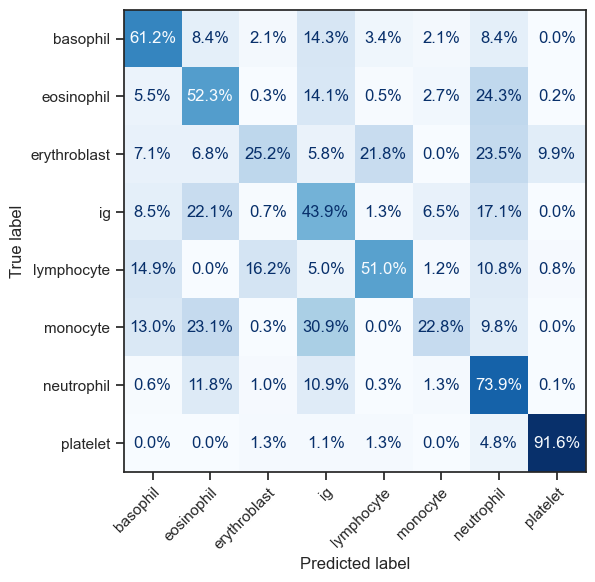

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

# confusion matrix oluşturma
fig, axes = plt.subplots(figsize=(10,6))
ConfusionMatrixDisplay.from_predictions(y_true=correct_labels,
                                        y_pred=predicted_labels,
                                        display_labels=segmented_class_names,
                                        normalize="true",
                                        cmap="Blues",
                                        values_format=".1%",
                                        colorbar=False,
                                        ax=axes)
axes.set_xticklabels(labels=segmented_class_names, rotation=45,
                     ha='right',
                     rotation_mode='anchor')
plt.show()

In [19]:
model.save(r"C:\Users\Gül\PycharmProjects\notebooks\56_segmented_model.keras")